# Project 1: Sex Differences in brain organization

### Main Script: ALL

## Load packages

In [1]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
import math
from math import isnan
import statistics
import pingouin as pg
import pickle

# Computing / Analyses
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
from statsmodels.stats.multitest import fdrcorrection # does not yield exactly the same FDR correction as R but the same up to 14th decimal place so good enough

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir_gsp = '/data/p_02667/sex_diff_gradients/results/GSP/'
resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/'
resdir_fig = '/data/p_02667/sex_diff_gradients/results/figures/'

## Import functions

In [3]:
%run p1_myfunctions.ipynb

# Data 

## Import the Yeo 7 network coding for the Schaefer 400 parcellation scheme 

(i.e., which network each parcel belongs to)



- **So a parcel cannot belong to more than 1 network..? LIMITATION NO? -> Yes. Shanmugan et al. (2022) for example use loading onto a network (i.e., not discrete)** 

In [4]:
# labels: 1=visual, 2=sensory motor, 3=dorsal attention, 4=ventral attention, 5=limbic, 6=fronto parietal, 7= DMN

with open(datadir+'yeo_7.csv') as f:
    reader = csv.reader(f)
    yeo7_networks = list(reader)[0]  # need [0] because the network values are contained in double brackets [[ ]]

Plotting the 7 Yeo networks on cortical surface

**TO DO:**
- no option of a map with 7 colors..? https://matplotlib.org/stable/tutorials/colors/colormaps.html
- there must be a better way of labelling the maps with actual names of networks (ie categorical)? maybe not, not the purpose of this plot hemispheres function


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


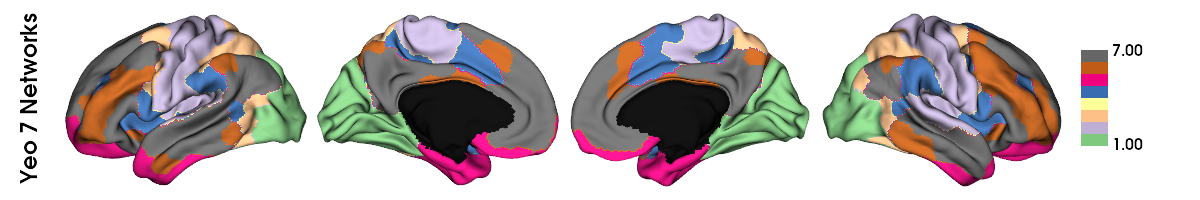

In [5]:
# need the the yeo network values (=dummy coding) to be in array format & float type in order to map_to_labels
yeo7_networks_array = []

for i in yeo7_networks:
    yeo7_networks_array.append(float(i))

yeo7_networks_array = np.asarray(yeo7_networks_array)



# defining labeling scheme and mask
labeling = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

networks = map_to_labels(yeo7_networks_array, labeling, mask=mask, fill=np.nan)  # mean_grad contains 10 .gradients_ (1 gradient per column) - here I take all rows and individual select column based on gradient I want (first 3)

plot_hemispheres(surf_lh, surf_rh, array_name=networks, embed_nb = True, size=(1200, 200), cmap='Accent', color_bar=True, label_text=['Yeo 7 Networks'], zoom=1.55)


## Network labels ('Accent' cmap):
# 1 visual (green)
# 2 sensory motor (purple)
# 3 dorsal attention (beige)
# 4 ventral attention (blue)
# 5 limbic (fuchsia)
# 6 fronto parietal (brown)
# 7 DMN (grey)

This palette is to be used for every time that Yeo networks are displayed in color (except (a) for showing the networks plotted on the hemispheres - this dictionary doesn't work as cmap for plot_hemispheres; (b) the pie charts - dictionary format not recognized)

In [6]:
# original Yeo network colors
palette_labeled_networks = {'DMN': 'indianred',  
                            'dorsal attention' : 'forestgreen',  
                            'fronto parietal' : 'orange',  
                            'limbic' : 'lemonchiffon',  
                            'sensory motor' : 'steelblue',
                            'ventral attention' : 'orchid', 
                            'visual' : 'darkorchid'} 

This is not needed for the raincloud plot, just for the scatterplot G1 v G2 displaying networks

In [7]:
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks:
    if i == '1':
        yeo7_networks_array_labels.append('visual')
    elif i == '2':
        yeo7_networks_array_labels.append('sensory motor')
    elif i == '3':
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == '4':
        yeo7_networks_array_labels.append('ventral attention')
    elif i == '5':
        yeo7_networks_array_labels.append('limbic')
    elif i == '6':
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == '7':
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)

In [8]:
network_names = ["visual", "sensory motor", "DMN", "dorsal attention", "ventral attention", "limbic", "fronto parietal"]

print("Number of parcels in each Yeo network:")
for i in range(len(network_names)):
    print(f"- {network_names[i]}: {yeo7_networks_array_labels.tolist().count(network_names[i])}")

Number of parcels in each Yeo network:
- visual: 61
- sensory motor: 77
- DMN: 90
- dorsal attention: 46
- ventral attention: 47
- limbic: 26
- fronto parietal: 53


## Fetch fsaverage parcellation (20484 vertices) coded for Schaefer 400 parcels - for Spin permutation tests

Spin permutation testing: https://enigma-toolbox.readthedocs.io/en/latest/pages/08.spintest/index.html -> requires data to be in fsaverage surface (not feasible with Schaefer parcellation)

**NOTE: schaefer_400_fs5 == 0 corresponds to midline (labels go from 0-400) -> disregard 0 in calculations and plotting**

In [9]:
# fetch the fsaverage parcellation labeling each of fsaverage5's 20484 vertices with its corresponding Schaefer parcel
schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400)

## Descriptive HCP

### Load data

In [10]:
restricted_data = pd.read_csv(datadir+'RESTRICTED_wanb_9_29_2020_2_14_36.csv')  # contains ACTUAL age, race, ethnicity, handedness, income, education, menstrual cycle info
print(f'Sample with demographic (restricted) data: N = {len(restricted_data)}')

#restricted_data.keys()
#for i in restricted_data.keys():
#    print(i)

unrestricted_data = pd.read_csv(datadir+'unrestricted_wanb_9_14_2020_7_53_51.csv')  # sex ('gender'), BINNED age (in 5-year increments, 22-25, 26-30, 31-35, 35+), ICV ('FS_IntraCranial_Vol')
print(f'Sample with demographic (unrestricted) data: N = {len(unrestricted_data)}')

#unrestricted_data.keys
#for i in unrestricted_data.keys():
#    print(i)

Sample with demographic (restricted) data: N = 1206
Sample with demographic (unrestricted) data: N = 1206


### Creating a merged demographic dataframe (from restricted and unrestricted data)

In [11]:
# merge based on index of both left dataset (unrestricted) and right dataset (restricted)
HCP_demographics_merged = pd.merge(restricted_data, unrestricted_data, left_index=True, right_index=True)

HCP_demographics_merged = HCP_demographics_merged.rename(columns={"Subject_x": "Subject"})

In [12]:
HCP_demographics_merged

Subject  Age_in_Yrs  HasGT ZygositySR ZygosityGT    Family_ID  \
0      100004          24   True    NotTwin             52259_82122   
1      100206          27   True    NotTwin             56037_85858   
2      100307          27   True      NotMZ         MZ  51488_81352   
3      100408          33   True         MZ         MZ  51730_81594   
4      100610          27   True      NotMZ         DZ  52813_82634   
...       ...         ...    ...        ...        ...          ...   
1201   992774          35   True    NotTwin             51345_81210   
1202   993675          29   True    NotTwin             55800_85621   
1203   994273          30   True    NotTwin             52364_82227   
1204   995174          25   True         MZ         MZ  55923_85743   
1205   996782          28   True      NotMZ         DZ  51541_81405   

      Mother_ID  Father_ID  TestRetestInterval   Race  ... Noise_Comp  \
0         52259      82122                 NaN  White  ...        5.2   
1         56037      85858                 NaN  White  ...        6.0   
2         51488      81352                 NaN  White  ...        3.6   
3         51730      81594                 NaN  White  ...        2.0   
4         52813      82634                 NaN  White  ...        2.0   
...         ...        ...                 ...    ...  ...        ...   
1201      51345      81210                 NaN  White  ...        8.4   
1202      55800      85621                 NaN  White  ...        0.4   
1203      52364      82227                 NaN  White  ...        6.0   
1204      55923      85743                 NaN  White  ...        3.6   
1205      51541      81405                 NaN  White  ...        6.0   

      Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  PainInterf_Tscore  \
0         101.12        86.45                  2.0               45.9   
1         108.79        97.19                  1.0               49.7   
2         101.12        86.45                  0.0               38.6   
3         108.79        98.04                  2.0               52.6   
4         122.25       110.45                  0.0               38.6   
...          ...          ...                  ...                ...   
1201      122.25       111.41                  4.0               50.1   
1202      122.25       110.45                  0.0               38.6   
1203      122.25       111.41                  7.0               63.8   
1204       88.61        64.58                  3.0               50.1   
1205      108.79        97.19                  0.0               38.6   

      Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  Mars_Final  
0          107.17        105.31            1.80        0.0        1.80  
1           72.63         72.03            1.84        0.0        1.84  
2           71.69         71.76            1.76        0.0        1.76  
3          114.01        113.59            1.76        2.0        1.68  
4           84.84         85.31            1.92        1.0        1.88  
...           ...           ...             ...        ...         ...  
1201       107.17        103.55            1.76        0.0        1.76  
1202        84.07         84.25            1.80        1.0        1.76  
1203       110.65        109.73            1.80        1.0        1.76  
1204       117.16        117.40            1.80        0.0        1.80  
1205        75.43         73.72            1.84        0.0        1.84  

[1206 rows x 786 columns]

### Final list of subjects with all data (FC, MPC, geodesic distance)

#### Load subject lists

In [13]:
HCP_sub_list_fc = pd.read_csv(datadir+'HCP_sub_list_fc.csv', header = None)[0].to_list()
len(HCP_sub_list_fc)

1014

In [14]:
HCP_sub_list_MPC = pd.read_csv(datadir+'HCP_sub_list_MPC.csv', header = None)[0].to_list()
len(HCP_sub_list_MPC)

1093

In [15]:
HCP_sub_list_geodesic = pd.read_csv(datadir+'geodesic_distance/HCP_sub_list_geodesic.csv', header = None)[0].to_list()
len(HCP_sub_list_geodesic)

1109

#### Make a final subject list that has all data (fc, MPC, geodesic distance)

In [16]:
HCP_sub_list_final = set.intersection(set(HCP_sub_list_fc), set(HCP_sub_list_MPC), set(HCP_sub_list_geodesic))
HCP_sub_list_final = list(HCP_sub_list_final)
HCP_sub_list_final.sort()
len(HCP_sub_list_final)

1000

### Final demographics dataframe including subjects  with all data (FC, MPC, geodesic distance)

In [17]:
# take a subset of the demographics dataframe - i.e., only subjects belonging to the final subjects list
HCP_demographics_cleaned = HCP_demographics_merged[HCP_demographics_merged["Subject"].isin(HCP_sub_list_final)]

In [18]:
HCP_demographics_cleaned

Subject  Age_in_Yrs  HasGT ZygositySR ZygosityGT          Family_ID  \
1      100206          27   True    NotTwin                   56037_85858   
2      100307          27   True      NotMZ         MZ        51488_81352   
3      100408          33   True         MZ         MZ        51730_81594   
4      100610          27   True      NotMZ         DZ        52813_82634   
5      101006          35   True         MZ             51283_52850_81149   
...       ...         ...    ...        ...        ...                ...   
1200   992673          33   True    NotTwin                   56143_85963   
1201   992774          35   True    NotTwin                   51345_81210   
1202   993675          29   True    NotTwin                   55800_85621   
1203   994273          30   True    NotTwin                   52364_82227   
1205   996782          28   True      NotMZ         DZ        51541_81405   

      Mother_ID  Father_ID  TestRetestInterval                  Race  ...  \
1         56037      85858                 NaN                 White  ...   
2         51488      81352                 NaN                 White  ...   
3         51730      81594                 NaN                 White  ...   
4         52813      82634                 NaN                 White  ...   
5         51283      81149                 NaN  Black or African Am.  ...   
...         ...        ...                 ...                   ...  ...   
1200      56143      85963                 NaN                 White  ...   
1201      51345      81210                 NaN                 White  ...   
1202      55800      85621                 NaN                 White  ...   
1203      52364      82227                 NaN                 White  ...   
1205      51541      81405                 NaN                 White  ...   

     Noise_Comp  Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  \
1           6.0      108.79        97.19                  1.0   
2           3.6      101.12        86.45                  0.0   
3           2.0      108.79        98.04                  2.0   
4           2.0      122.25       110.45                  0.0   
5           6.0      122.25       111.41                  0.0   
...         ...         ...          ...                  ...   
1200        3.6      122.25       111.41                  1.0   
1201        8.4      122.25       111.41                  4.0   
1202        0.4      122.25       110.45                  0.0   
1203        6.0      122.25       111.41                  7.0   
1205        6.0      108.79        97.19                  0.0   

      PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
1                  49.7        72.63         72.03            1.84        0.0   
2                  38.6        71.69         71.76            1.76        0.0   
3                  52.6       114.01        113.59            1.76        2.0   
4                  38.6        84.84         85.31            1.92        1.0   
5                  38.6       123.80        123.31            1.80        0.0   
...                 ...          ...           ...             ...        ...   
1200               38.6       101.63         99.26            1.80        0.0   
1201               50.1       107.17        103.55            1.76        0.0   
1202               38.6        84.07         84.25            1.80        1.0   
1203               63.8       110.65        109.73            1.80        1.0   
1205               38.6        75.43         73.72            1.84        0.0   

      Mars_Final  
1           1.84  
2           1.76  
3           1.68  
4           1.88  
5           1.80  
...          ...  
1200        1.80  
1201        1.76  
1202        1.76  
1203        1.76  
1205        1.84  

[1000 rows x 786 columns]

#### adding variables to the dataframe

##### creating and adding to the demographics dataframe a numerical variable for sex (for including sex as a covariate in partial correlation, throws error if include 'M' 'F' lables)

In [19]:
sex_num = []


for sex_letter in HCP_demographics_cleaned.Gender:
    
    if sex_letter == 'M':
        sex_num.append(0)
        
    elif sex_letter == 'F':
        sex_num.append(1)
        
    else:  # just in case, but there are none
        sex_num.append('n/a') 

HCP_demographics_cleaned['sex_num'] = sex_num

/tmp/ipykernel_11903/2970297418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HCP_demographics_cleaned['sex_num'] = sex_num


##### Creating a variable describing twin status (MZ, DZ, sibling, unrelated)
This is for linear mixed effect model -> controling for family and twin status 

In [20]:
### Make a list containing the family IDs that have multiple siblings

HCP_family_IDs = []  # contains all family IDs (without duplicates)
HCP_family_IDs_related = []  # contains family IDs of subjects that have relatives in sample ("duplicated" family IDs) - each ID appearing only 1x

# loop over all subjects
for i in range(len(HCP_demographics_cleaned)):
   
    # conditions to append family ID in HCP_family_IDs_related df:
    # if the current sub's family ID is already in the HCP_family_IDs, it means that we have looped over this family ID before therefore there are siblings sharing this family_ID in the dataset; AND
    # because we don't want duplicate family IDs in HCP_family_IDs_related: if the current sub's family ID is not yet in HCP_family_IDs_related -> we need to append it
    if (HCP_demographics_cleaned.Family_ID.iloc[i] in HCP_family_IDs) & (HCP_demographics_cleaned.Family_ID.iloc[i] not in HCP_family_IDs_related):
        HCP_family_IDs_related.append(HCP_demographics_cleaned.Family_ID.iloc[i])
    
    if HCP_demographics_cleaned.Family_ID.iloc[i] not in HCP_family_IDs: 
        HCP_family_IDs.append(HCP_demographics_cleaned.Family_ID.iloc[i])
        
        
        
### create a list containing (in order of participants) those that have other family members in the sample based on their family ID (if it is present in list HCP_family_IDs_related)

family_members_in_sample = []

for i in HCP_demographics_cleaned['Family_ID'] :
    if i in HCP_family_IDs_related:
        family_members_in_sample.append(1)
    else:
        family_members_in_sample.append(0)



### create a new variable variable that specifies the twin status (i.e., MZ, DZ, sibling, unrelated)
# based on family_members_in_sample and Zygosity variables 
    # ZygosityGT (determined via genotyping) should be given precedence over ZygositySR (self-reported) 
    # Genotyping was only done when both subjects in a twin pair to have HasGT=TRUE to have a value (if genotyping is not available for either of a twin pair, no values are given for ZygosityGT)
    # Non-twin subjects also do not have a value for ZygosityGT
    # Note that some subjects self-reported as dizygotic twins (ZygositySR='NotMZ') but genotyping established that they were monozygotic twins (thence ZygosityGT='MZ' for those subjects)
    # including the empty ZygosityGT condition so that ZygositySR does not override GT    

TwinStatus = []

for i in range(len(HCP_demographics_cleaned)):
    if family_members_in_sample[i] == 1:
        if HCP_demographics_cleaned.ZygosityGT.iloc[i] == 'MZ' or (HCP_demographics_cleaned.ZygosityGT.iloc[i] == ' ' and HCP_demographics_cleaned.ZygositySR.iloc[i] == 'MZ'):
            TwinStatus.append('MZ')
        elif HCP_demographics_cleaned.ZygosityGT.iloc[i] == 'DZ' or (HCP_demographics_cleaned.ZygosityGT.iloc[i] == ' ' and HCP_demographics_cleaned.ZygositySR.iloc[i] == 'NotMZ'):
            TwinStatus.append('DZ')
        else:
            TwinStatus.append('sibling')
    elif family_members_in_sample[i] == 0:
        TwinStatus.append('unrelated')

HCP_demographics_cleaned['TwinStatus'] = TwinStatus



### creating a numerical version of TwinStatus variable (for including TwinStatus as a covariate in partial correlation, throws error if include string lables)
TwinStatus_num = []


for twinstatus_letter in HCP_demographics_cleaned.TwinStatus:
    
    if twinstatus_letter == 'MZ':
        TwinStatus_num.append(0)
        
    elif twinstatus_letter == 'DZ':
        TwinStatus_num.append(1)
    
    elif twinstatus_letter == 'sibling':
        TwinStatus_num.append(2)
    
    elif twinstatus_letter == 'unrelated':
        TwinStatus_num.append(3)

HCP_demographics_cleaned['TwinStatus_num'] = TwinStatus_num
#HCP_demographics_cleaned.TwinStatus_num.value_counts()

/tmp/ipykernel_11903/3645008470.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HCP_demographics_cleaned['TwinStatus'] = TwinStatus
/tmp/ipykernel_11903/3645008470.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HCP_demographics_cleaned['TwinStatus_num'] = TwinStatus_num


In [21]:
# for some reason, the partial correlation does not work when including Family_ID large numbers (10 digits <) as covariate - therefore, here we create new family IDs starting from 1 (whilst of course preserving family relatedness)

# dictionary that will include the correspondance of original IDs and new IDs (only for related individuals, unrelated will be easily numbered on top)
fam_ID_correspondance_dict = {}

for i in range(len(HCP_family_IDs_related)):
    
    # create a new dictionary entry with the original family ID and it's new corresponding family ID (starting with 1 not to make any issue with zero) -> IDs going from 1 to 347 (as there are 347 related families in sample)
    fam_ID_correspondance_dict[HCP_family_IDs_related[i]] = i+1

    
# creating a new variable for dataframe which will contain the new family IDs     
Family_ID_num = []
n = 0  

# iterate over all family IDs
for family_id in HCP_demographics_cleaned.Family_ID:
    
    # if it's a family ID of a family that has related individuals in sample, go fetch its new family ID in the dictionary and append it to the list
    if family_id in HCP_family_IDs_related:
        Family_ID_num.append(fam_ID_correspondance_dict[family_id])
    
    # if it's the family ID of an unrelated individual, create a new family ID by adding n to the len(family_related) (i.e., 347) - n is also being incremented each time we come across an unrelated subject in loop
    else:
        n += 1
        Family_ID_num.append(len(HCP_family_IDs_related)+n) # new family IDs for unrelated individuals

HCP_demographics_cleaned['Family_ID_num'] = Family_ID_num

/tmp/ipykernel_11903/4142279548.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HCP_demographics_cleaned['Family_ID_num'] = Family_ID_num


#### Final demographics

In [22]:
HCP_demographics_cleaned_final = HCP_demographics_cleaned.copy()

In [23]:
HCP_demographics_cleaned_final

Subject  Age_in_Yrs  HasGT ZygositySR ZygosityGT          Family_ID  \
1      100206          27   True    NotTwin                   56037_85858   
2      100307          27   True      NotMZ         MZ        51488_81352   
3      100408          33   True         MZ         MZ        51730_81594   
4      100610          27   True      NotMZ         DZ        52813_82634   
5      101006          35   True         MZ             51283_52850_81149   
...       ...         ...    ...        ...        ...                ...   
1200   992673          33   True    NotTwin                   56143_85963   
1201   992774          35   True    NotTwin                   51345_81210   
1202   993675          29   True    NotTwin                   55800_85621   
1203   994273          30   True    NotTwin                   52364_82227   
1205   996782          28   True      NotMZ         DZ        51541_81405   

      Mother_ID  Father_ID  TestRetestInterval                  Race  ...  \
1         56037      85858                 NaN                 White  ...   
2         51488      81352                 NaN                 White  ...   
3         51730      81594                 NaN                 White  ...   
4         52813      82634                 NaN                 White  ...   
5         51283      81149                 NaN  Black or African Am.  ...   
...         ...        ...                 ...                   ...  ...   
1200      56143      85963                 NaN                 White  ...   
1201      51345      81210                 NaN                 White  ...   
1202      55800      85621                 NaN                 White  ...   
1203      52364      82227                 NaN                 White  ...   
1205      51541      81405                 NaN                 White  ...   

     PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
1                 49.7        72.63         72.03            1.84        0.0   
2                 38.6        71.69         71.76            1.76        0.0   
3                 52.6       114.01        113.59            1.76        2.0   
4                 38.6        84.84         85.31            1.92        1.0   
5                 38.6       123.80        123.31            1.80        0.0   
...                ...          ...           ...             ...        ...   
1200              38.6       101.63         99.26            1.80        0.0   
1201              50.1       107.17        103.55            1.76        0.0   
1202              38.6        84.07         84.25            1.80        1.0   
1203              63.8       110.65        109.73            1.80        1.0   
1205              38.6        75.43         73.72            1.84        0.0   

      Mars_Final  sex_num  TwinStatus  TwinStatus_num  Family_ID_num  
1           1.84        0     sibling               2            115  
2           1.76        1          MZ               0            149  
3           1.68        0          MZ               0             38  
4           1.88        0          DZ               1              8  
5           1.80        1          MZ               0              1  
...          ...      ...         ...             ...            ...  
1200        1.80        1     sibling               2            340  
1201        1.76        0     sibling               2            272  
1202        1.76        1     sibling               2            341  
1203        1.76        0     sibling               2            200  
1205        1.84        1          DZ               1            317  

[1000 rows x 790 columns]

In [24]:
print(f"N = {len(HCP_demographics_cleaned_final)}\n"
      f"{np.sum(HCP_demographics_cleaned_final.Gender == 'F')} females, {np.sum(HCP_demographics_cleaned_final.Gender == 'M')} males\n"
      f"Mean subject age: {np.mean(HCP_demographics_cleaned_final.Age_in_Yrs):.2f}, SD: {np.std(HCP_demographics_cleaned_final.Age_in_Yrs):.2f}, range: {np.min(HCP_demographics_cleaned_final.Age_in_Yrs):.2f} - {np.max(HCP_demographics_cleaned_final.Age_in_Yrs):.2f}\n"
      f"Mean ICV: {np.mean(HCP_demographics_cleaned_final.FS_IntraCranial_Vol):.2f}, SD: {np.std(HCP_demographics_cleaned_final.FS_IntraCranial_Vol):.2f}, range: {np.min(HCP_demographics_cleaned_final.FS_IntraCranial_Vol):.2f} - {np.max(HCP_demographics_cleaned_final.FS_IntraCranial_Vol):.2f}\n"
      f"Sample relatedness: {np.sum(HCP_demographics_cleaned_final.TwinStatus == 'MZ')} MZ twins, {np.sum(HCP_demographics_cleaned_final.TwinStatus == 'DZ')} DZ twins, {np.sum(HCP_demographics_cleaned_final.TwinStatus == 'sibling')} other siblings, {np.sum(HCP_demographics_cleaned_final.TwinStatus == 'unrelated')} unrelated individuals"
     )

N = 1000
536 females, 464 males
Mean subject age: 28.73, SD: 3.71, range: 22.00 - 37.00
Mean ICV: 1584000.48, SD: 187267.82, range: 831208.30 - 2143193.92
Sample relatedness: 284 MZ twins, 184 DZ twins, 443 other siblings, 89 unrelated individuals


#### Export demographics dataframe to csv for R analyses

In [25]:
HCP_demographics_cleaned_final.to_csv(resdir_hcp+'demographics_cleaned_final.csv', header = True, index = True)

### Testing differences in age between the sexes (given that I will test sex differences without matching for age)

In [26]:
# Levene's test for equality of variances -> non-significant differences means equality, can contiunue with parametric independent samples t-test
stats.levene(HCP_demographics_cleaned_final.Age_in_Yrs[HCP_demographics_cleaned_final.Gender == 'M'], HCP_demographics_cleaned_final.Age_in_Yrs[HCP_demographics_cleaned_final.Gender == 'F'])

LeveneResult(statistic=0.09030762176822477, pvalue=0.763849030139735)

In [27]:
stats.ttest_ind(HCP_demographics_cleaned_final.Age_in_Yrs[HCP_demographics_cleaned_final.Gender == 'M'], HCP_demographics_cleaned_final.Age_in_Yrs[HCP_demographics_cleaned_final.Gender == 'F'])

Ttest_indResult(statistic=-6.820637739913875, pvalue=1.5684992753964304e-11)

Text(0, 0.5, 'Frequency')

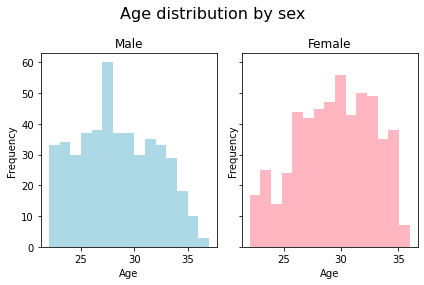

In [28]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

fig.suptitle('Age distribution by sex', fontsize=16)

axs[0].hist(HCP_demographics_cleaned_final.Age_in_Yrs[HCP_demographics_cleaned_final.Gender == 'M'], bins=15, color = 'lightblue')
axs[0].set_title('Male')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

axs[1].hist(HCP_demographics_cleaned_final.Age_in_Yrs[HCP_demographics_cleaned_final.Gender == 'F'], bins=15, color = 'lightpink')
axs[1].set_title('Female')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

## FC data 

In [29]:
# fc matrices
scipy.io.whosmat(datadir+'fc_matrices/fc_matrices.mat')

[('HCP_fc_matrices', (1014, 400, 400), 'double'),
 ('HCP_sub_list_fc', (1014,), 'char'),
 ('GSP_fc_matrices', (1568, 400, 400), 'double'),
 ('GSP_sub_list_fc', (1568,), 'char')]

In [30]:
# taking the MPC matrices from the mat file
fc_matrices_full = scipy.io.loadmat(datadir+'fc_matrices/fc_matrices.mat')['HCP_fc_matrices']

### Get subsample of fc matrices that has full data (matching HCP_sub_list_final)

In [31]:
# list that will contain the fc matrices in final sample
fc_matrices = []

for i in range(len(HCP_sub_list_fc)):
    if HCP_sub_list_fc[i] in HCP_sub_list_final:
        
        # append this subjects' list of fc matrices to the list of fc matrices in final sample
        fc_matrices.append(fc_matrices_full[i])
    
fc_matrices = np.array(fc_matrices)

In [32]:
fc_matrices.shape

(1000, 400, 400)

## MPC data 

In [33]:
# MPC matrices
scipy.io.whosmat(datadir+'HCP_microstructure/MPC_matrices_no_missing.mat')

[('MPC_matrices', (1093, 400, 400), 'double'),
 ('HCP_sub_list_MPC', (1, 1093), 'int64')]

In [34]:
# taking the MPC matrices from the mat file
MPC_matrices_full = scipy.io.loadmat(datadir+'HCP_microstructure/MPC_matrices_no_missing.mat')['MPC_matrices']

### Get subsample of MPC matrices that has full data (matching HCP_sub_list_final)

In [35]:
# list that will contain the MPC matrices in final sample
MPC_matrices = []

for i in range(len(HCP_sub_list_MPC)):
    if HCP_sub_list_MPC[i] in HCP_sub_list_final:
        
        # append this subjects' list of fc matrices to the list of fc matrices in final sample
        MPC_matrices.append(MPC_matrices_full[i])
    
MPC_matrices = np.array(MPC_matrices)

In [36]:
MPC_matrices.shape

(1000, 400, 400)

## Geodesic distance data 

In [37]:
# mean of top 10% of distances per parcel per subject
mean_top_geodesic_distances_full = np.genfromtxt(datadir+'geodesic_distance/mean_top_geodesic_distances.csv', delimiter=',')

In [38]:
mean_top_geodesic_distances_full.shape

(1109, 402)

In [39]:
# matrices of raw geodesic distances (intra hemispheric)
scipy.io.whosmat(datadir+'geodesic_distance/geodesic_distances_matrices.mat')

[('geodesic_distances_matrices', (1109, 402, 402), 'double')]

In [40]:
# taking the MPC matrices from the mat file
geodesic_distances_matrices_full = scipy.io.loadmat(datadir+'geodesic_distance/geodesic_distances_matrices.mat')['geodesic_distances_matrices']

In [41]:
geodesic_distances_matrices_full.shape

(1109, 402, 402)

### Get subsample of geodesic distance data that has full data (matching HCP_sub_list_final)

In [42]:
# list that will contain the mean of the top geodesic distances in final sample
mean_top_geodesic_distances = []

for i in range(len(HCP_sub_list_geodesic)):
    if HCP_sub_list_geodesic[i] in HCP_sub_list_final:
        
        # append this subjects' list of mean top geodesic distances to the list of mean of the top geodesic distances in final sample
        mean_top_geodesic_distances.append(mean_top_geodesic_distances_full[i])
        
    
mean_top_geodesic_distances = np.array(mean_top_geodesic_distances)

In [43]:
mean_top_geodesic_distances.shape

(1000, 402)

# Computing functional gradients

## Mean gradients

*Needed for figures and for computing aligned gradients*

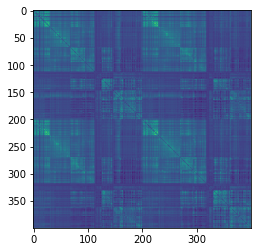

(400, 400)


'/data/p_02667/sex_diff_gradients/results/figures/HCP_fc_plotted_hemispheres_mean_gradients.png'

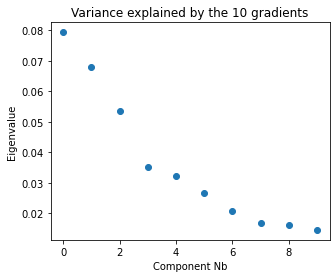

Total amount of variance explained by the 10 gradients (uncorrected sum lambdas): 0.36

Scaled variance explained by individual gradients:
G1: 21.85%
G2: 18.71%
G3: 14.72%



In [44]:
# compute the mean connectivity matrix (by averaging the connectivity matrices of all subjects)
mean_fc_matrix = sum(fc_matrices)/len(fc_matrices)

# compute mean gradients
mean_fc_grad = compute_mean_gradients(mean_conn_matrix = mean_fc_matrix, display_output = True, data_reduction_algorithm = 'dm', save_screenshot = True, sample_modality = 'HCP_fc')

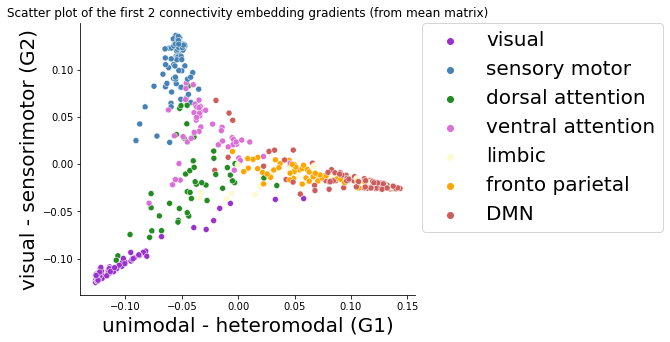

In [45]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=mean_fc_grad.gradients_[:,0],  # all rows (400 parces), first column (G1: unimodal - heteromodal)
                     y=mean_fc_grad.gradients_[:,1],  # all rows (400 parces), second column (G2: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks,
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G1)', fontsize = 20);
ax.set_ylabel('visual - sensorimotor (G2)', fontsize = 20);
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')

ax.legend(fontsize=20, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
#ax.legend(loc=2, prop={'size': 6})

plt.show(ax)

## Aligned gradients

Construct gradients for all subjects (procrustes alignment to the overall mean matrix)

In [ ]:
compute_aligned_grad = compute_aligned_gradients(fc_matrices, mean_fc_grad.gradients_)

# storing the output of the computation of the aligned gradients
#array_aligned_gradients = compute_aligned_grad['array_aligned_gradients']
array_aligned_fc_G1 = compute_aligned_grad['array_aligned_G1']
array_aligned_fc_G2 = compute_aligned_grad['array_aligned_G2']
array_aligned_fc_G3 = compute_aligned_grad['array_aligned_G3']

### Exporting Gradients to csv for R analyses

In [ ]:
# fmt = decimals, header = 1 to 400 (without the first and last string letter because it's the [] of the list, comments = empty because otherwise gives a #

np.savetxt(resdir_hcp+'array_aligned_fc_G1.csv', array_aligned_fc_G1, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')
np.savetxt(resdir_hcp+'array_aligned_fc_G2.csv', array_aligned_fc_G2, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')
np.savetxt(resdir_hcp+'array_aligned_fc_G3.csv', array_aligned_fc_G3, delimiter=',', fmt = '%.16g', header = str(list(range(1,401)))[1:-1], comments = '')

## Mean gradients by sex

*Needed for computing variability & for plotting (mean) Males vs (mean) Females if plan to replicate figure from Hong et al https://www.nature.com/articles/s41467-019-08944-1/figures/3*


In [ ]:
# creating lists containing only male and only female fc matrices

fc_matrices_M = []
fc_matrices_F = []

for i in range(len(fc_matrices)):
    if HCP_demographics_cleaned_final.Gender.iloc[i] == "M":
        fc_matrices_M.append(fc_matrices[i])
    elif HCP_demographics_cleaned_final.Gender.iloc[i] == "F":
        fc_matrices_F.append(fc_matrices[i])

### Males

In [ ]:
# compute the mean connectivity matrix (by averaging the connectivity matrices of all males)
mean_fc_matrix_M = sum(fc_matrices_M)/len(fc_matrices_M)

# compute mean gradients
mean_fc_grad_M = compute_mean_gradients(mean_conn_matrix = mean_fc_matrix_M, display_output = True, data_reduction_algorithm = 'dm', save_screenshot = False, sample_modality = 'HCP_fc_M')

### Females

In [ ]:
# compute the mean connectivity matrix (by averaging the connectivity matrices of all females)
mean_fc_matrix_F = sum(fc_matrices_F)/len(fc_matrices_F)

# compute mean gradients
mean_fc_grad_F = compute_mean_gradients(mean_conn_matrix = mean_fc_matrix_F, display_output = True, data_reduction_algorithm = 'dm', save_screenshot = False, sample_modality = 'HCP_fc_F')

In [ ]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=mean_fc_grad_M.gradients_[:,0],  # all rows (400 parces), first column (G1: unimodal - heteromodal)
                     y=mean_fc_grad_M.gradients_[:,1],  # all rows (400 parces), second column (G2: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks,
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G1)');
ax.set_ylabel('visual - sensorimotor (G2)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

In [ ]:
# scatterplot
fig, ax = plt.subplots(figsize=(6,5));
ax = sns.scatterplot(x=mean_fc_grad_F.gradients_[:,0],  # all rows (400 parces), first column (G1: unimodal - heteromodal)
                     y=mean_fc_grad_F.gradients_[:,1],  # all rows (400 parces), second column (G2: visual - somatomotor)
                     hue=yeo7_networks_array_labels,  # gives color coding based on yeo networks
                     palette=palette_labeled_networks,
                     legend=True, ax=ax);

ax.set_xlabel('unimodal - heteromodal (G1)');
ax.set_ylabel('visual - sensorimotor (G2)');
ax.set_title("Scatter plot of the first 2 connectivity embedding gradients (from mean matrix)")
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
plt.legend(title='Yeo networks')
plt.show(ax)

### Males vs Females

In [ ]:
# plotting HCP G2 mean loadings
plot_mean_parcel_values_scatter_bysex(male_data = mean_fc_grad_M.gradients_[:,0], female_data = mean_fc_grad_F.gradients_[:,0], title = 'Mean Functional Gradient Loadings (HCP)')

## Aligned gradients by sex 
*Needed to compute variability within sexes*

In [ ]:
### Males

compute_aligned_grad_M = compute_aligned_gradients(fc_matrices_M, mean_fc_grad_M.gradients_)

# storing the output of the computation of the aligned gradients
#array_aligned_gradients = compute_aligned_grad['array_aligned_gradients']
array_aligned_fc_G1_M = compute_aligned_grad_M['array_aligned_G1']
array_aligned_fc_G2_M = compute_aligned_grad_M['array_aligned_G2']
array_aligned_fc_G3_M = compute_aligned_grad_M['array_aligned_G3']


### Females

compute_aligned_grad_F = compute_aligned_gradients(fc_matrices_F, mean_fc_grad_F.gradients_)

# storing the output of the computation of the aligned gradients
#array_aligned_gradients = compute_aligned_grad['array_aligned_gradients']
array_aligned_fc_G1_F = compute_aligned_grad_F['array_aligned_G1']
array_aligned_fc_G2_F = compute_aligned_grad_F['array_aligned_G2']
array_aligned_fc_G3_F = compute_aligned_grad_F['array_aligned_G3']

# Variability (individual- and sex-level) (HCP) in gradient loadings

## 1. Whole brain level: Correlating individual subject gradient loadings with HCP mean gradient loadings (to see deviations from the mean)

### Unimodal-heteromodal gradient

Compared to 0.3-0.9 range of correlation coefficients when comparing individual level GSP gradient loading with mean HCP

Correlation of individual gradient loadings to mean gradient loadings (age ordered)


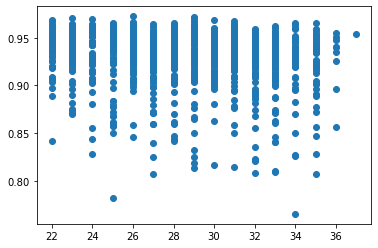

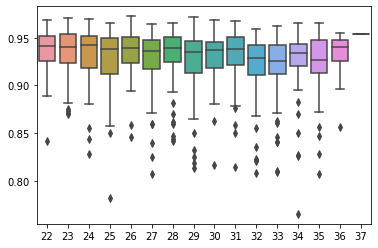

Correlation of individual gradient loadings to mean gradient loadings of given sex (color-coded by sex)


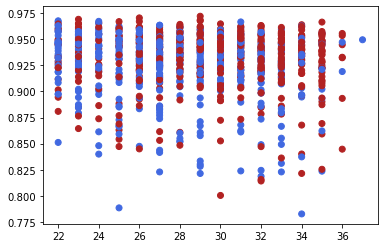

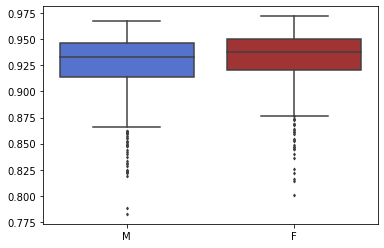

Mean correlation coefficient of male individual gradients and mean male gradient: M = 0.92; SD = 0.032
Mean correlation coefficient of female individual gradients and mean female gradient: M = 0.93; SD = 0.027



In [35]:
variability_wholebrain_corr_to_mean(mean_grad = mean_fc_grad.gradients_[:,0], mean_grad_M = mean_fc_grad_M.gradients_[:,0], mean_grad_F = mean_fc_grad_F.gradients_[:,0], subject_grad = array_aligned_fc_G1, subject_ages =  HCP_demographics_cleaned_final.Age_in_Yrs.tolist(), subject_sexes = HCP_demographics_cleaned_final.Gender.tolist())

### Visual-sensorimotor gradient

#### Comparing individual gradients to overall mean (ordered by age)

To study variability as a function of age

Correlation of individual gradient loadings to mean gradient loadings (age ordered)


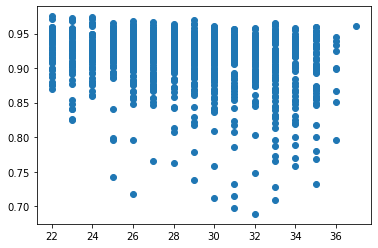

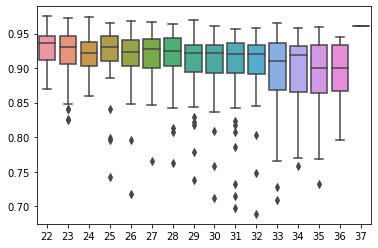

Correlation of individual gradient loadings to mean gradient loadings of given sex (color-coded by sex)


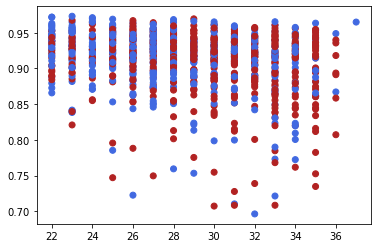

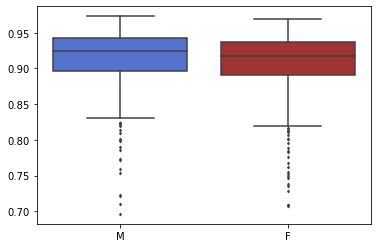

Mean correlation coefficient of male individual gradients and mean male gradient: M = 0.92; SD = 0.041
Mean correlation coefficient of female individual gradients and mean female gradient: M = 0.91; SD = 0.044



In [36]:
variability_wholebrain_corr_to_mean(mean_grad = mean_fc_grad.gradients_[:,1], mean_grad_M = mean_fc_grad_M.gradients_[:,1], mean_grad_F = mean_fc_grad_F.gradients_[:,1], subject_grad = array_aligned_fc_G2, subject_ages =  HCP_demographics_cleaned_final.Age_in_Yrs.tolist(), subject_sexes = HCP_demographics_cleaned_final.Gender.tolist())

## 2. Parcel level: Visualizing standard deviation by parcels in both sexes separately

To visualize which sex and parcels have most variability

Number of parcels for which there males have a statistically significant larger variance than females: 30
Number of parcels for which there females have a statistically significant larger variance than males: 51
Number of parcels for which there males have a statistically significant larger variance than females after FDR-correction: 5
Number of parcels for which there females have a statistically significant larger variance than males after FDR-correction: 13

Minimum SD: Males = 0.013; Females = 0.014
Maximum SD: Males = 0.065; Females = 0.068


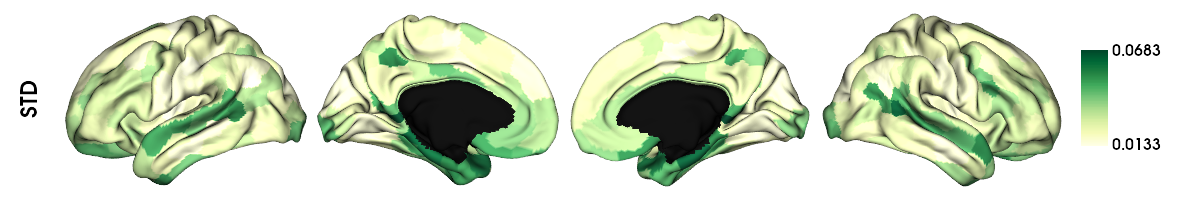

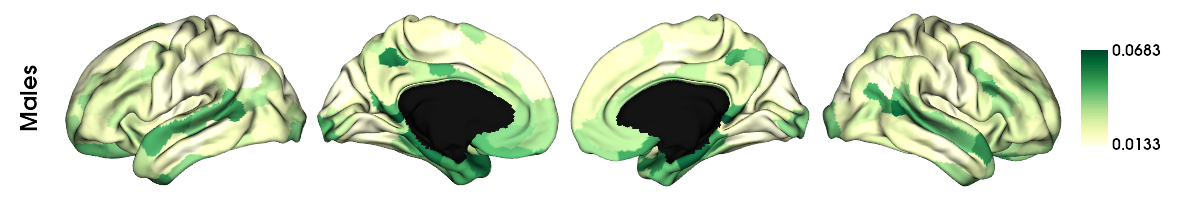

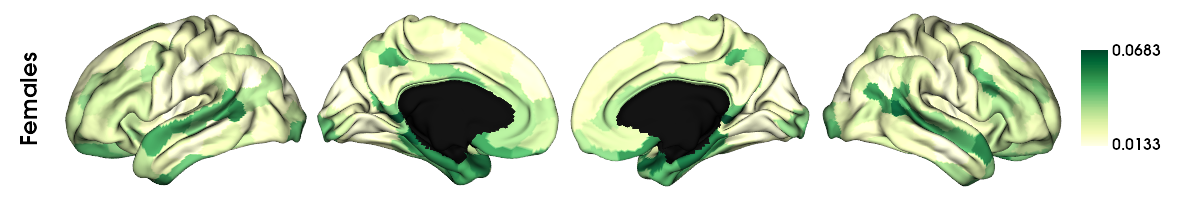

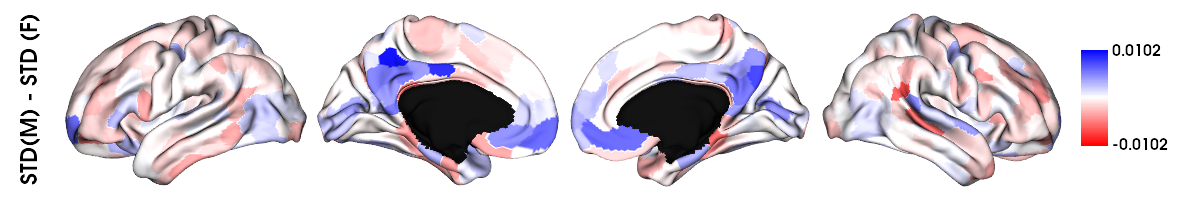

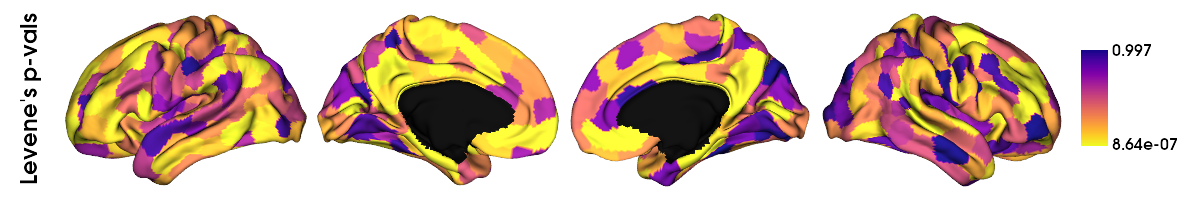

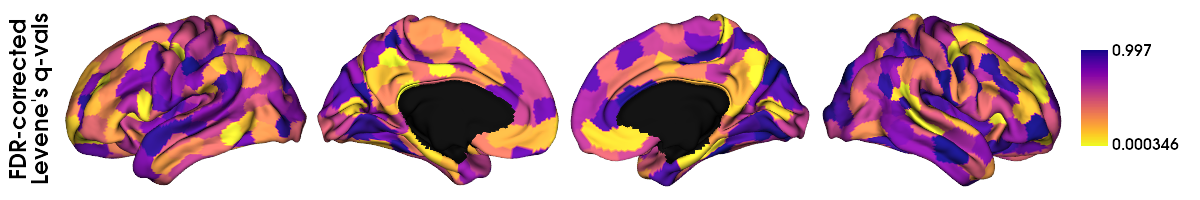

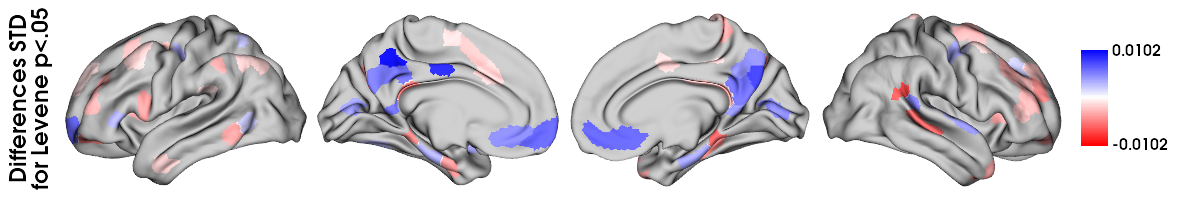

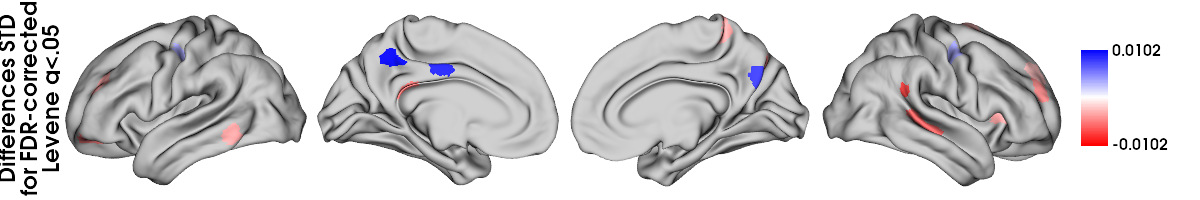

Number of significant parcels: 18

Number of significant parcels for males: 5
Number of significant parcels for females: 13

Number of significant parcels in each Yeo network (across sexes):
- visual: 0 out of 61 (0.0%) -> 0.0% of overall significance
- sensory motor: 3 out of 77 (3.9%) -> 16.67% of overall significance
- DMN: 7 out of 90 (7.78%) -> 38.89% of overall significance
- dorsal attention: 0 out of 46 (0.0%) -> 0.0% of overall significance
- ventral attention: 4 out of 47 (8.51%) -> 22.22% of overall significance
- limbic: 0 out of 26 (0.0%) -> 0.0% of overall significance
- fronto parietal: 4 out of 53 (7.55%) -> 22.22% of overall significance





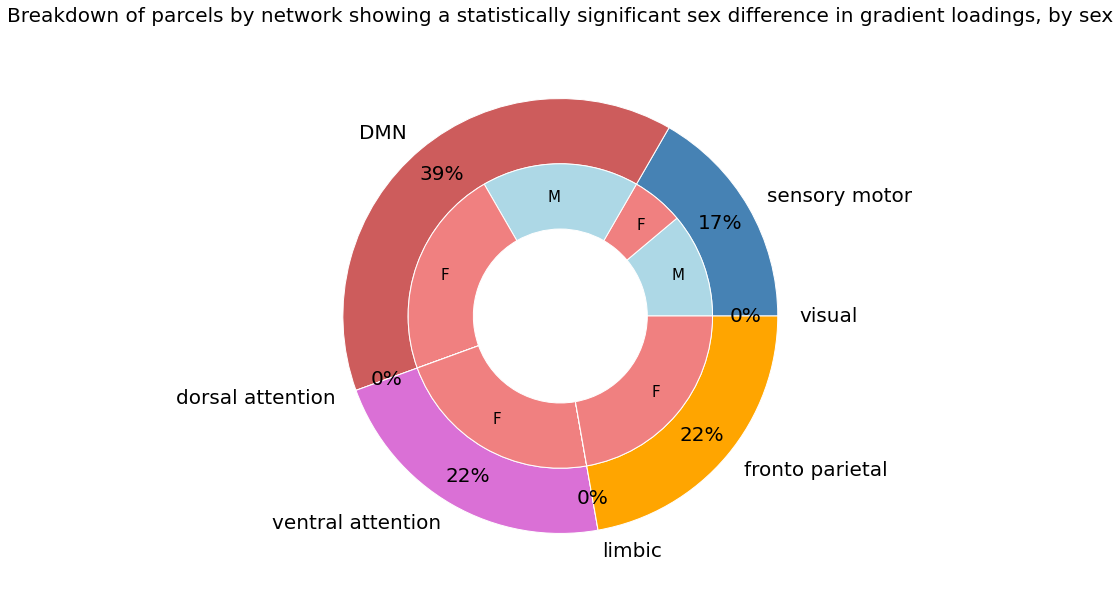

Number of significant parcels by sex:
visual - Male: 0, Female: 0
sensory motor - Male: 2, Female: 1
DMN - Male: 3, Female: 4
dorsal attention - Male: 0, Female: 0
ventral attention - Male: 0, Female: 4
limbic - Male: 0, Female: 0
fronto parietal - Male: 0, Female: 4





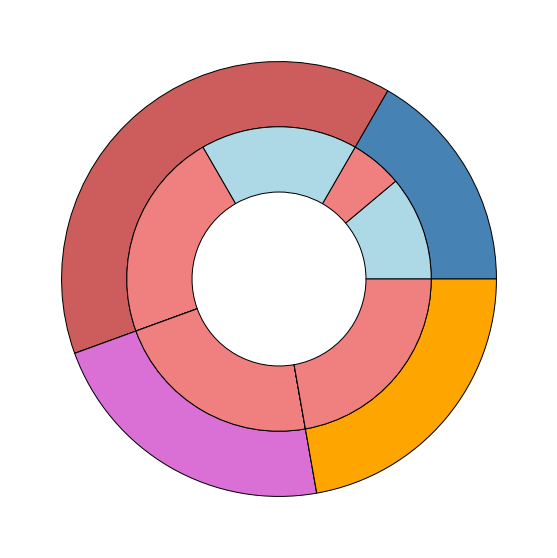

In [41]:
variability_parcel_std(subject_grad = array_aligned_fc_G1, subject_grad_M = array_aligned_fc_G1_M, subject_grad_F = array_aligned_fc_G1_F, save_plots = False, sample_modality = 'HCP_fc_G1')

## 3. Network level

### a) Correlation coefficient -> Correlating individual subject gradient loadings with mean gradient loadings (by sex) 

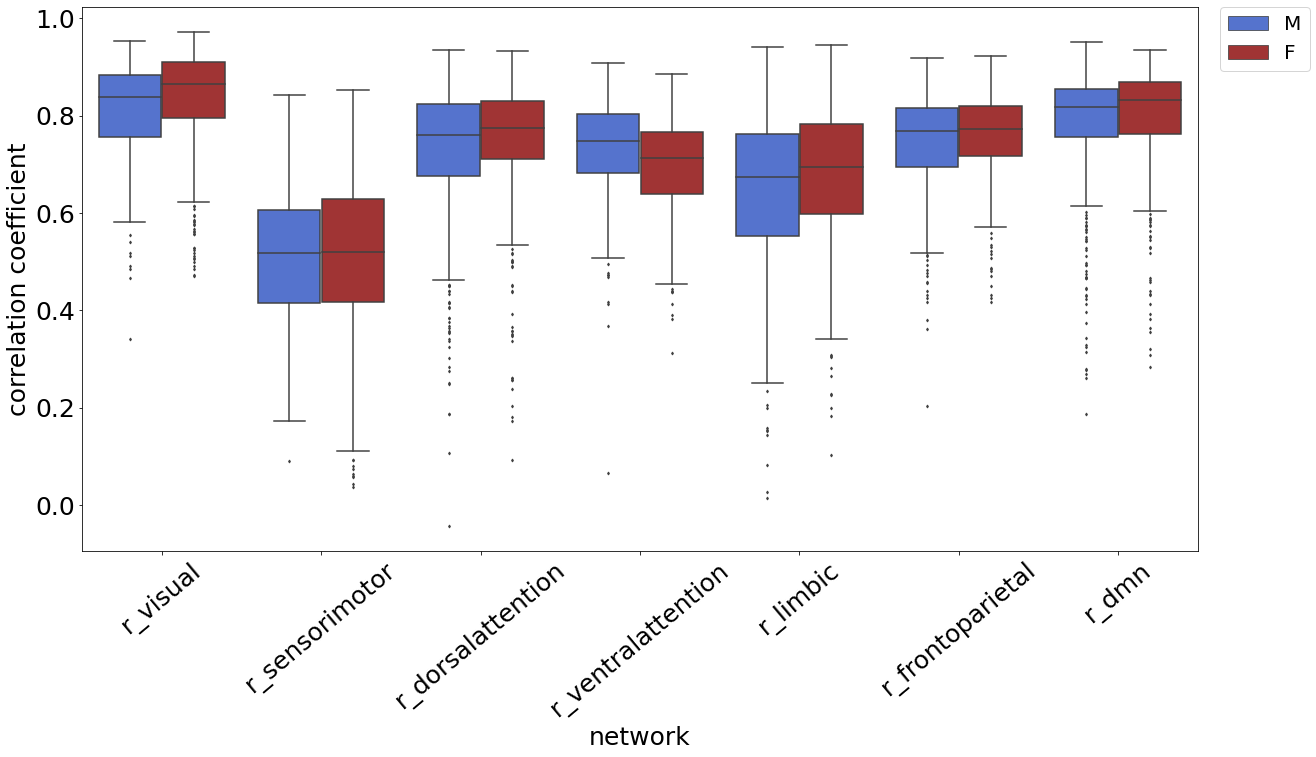

In [38]:
# CAUTION: function is hard-coded for mean G1

variability_network_corr_to_mean_G1(mean_grad = mean_fc_grad.gradients_, mean_grad_M = mean_fc_grad_M.gradients_, mean_grad_F = mean_fc_grad_F.gradients_, subject_grad = array_aligned_fc_G1, subject_grad_M = array_aligned_fc_G1_M, subject_grad_F = array_aligned_fc_G1_F) 

### b) STD -> Mean standard deviation across parcels belonging to same network

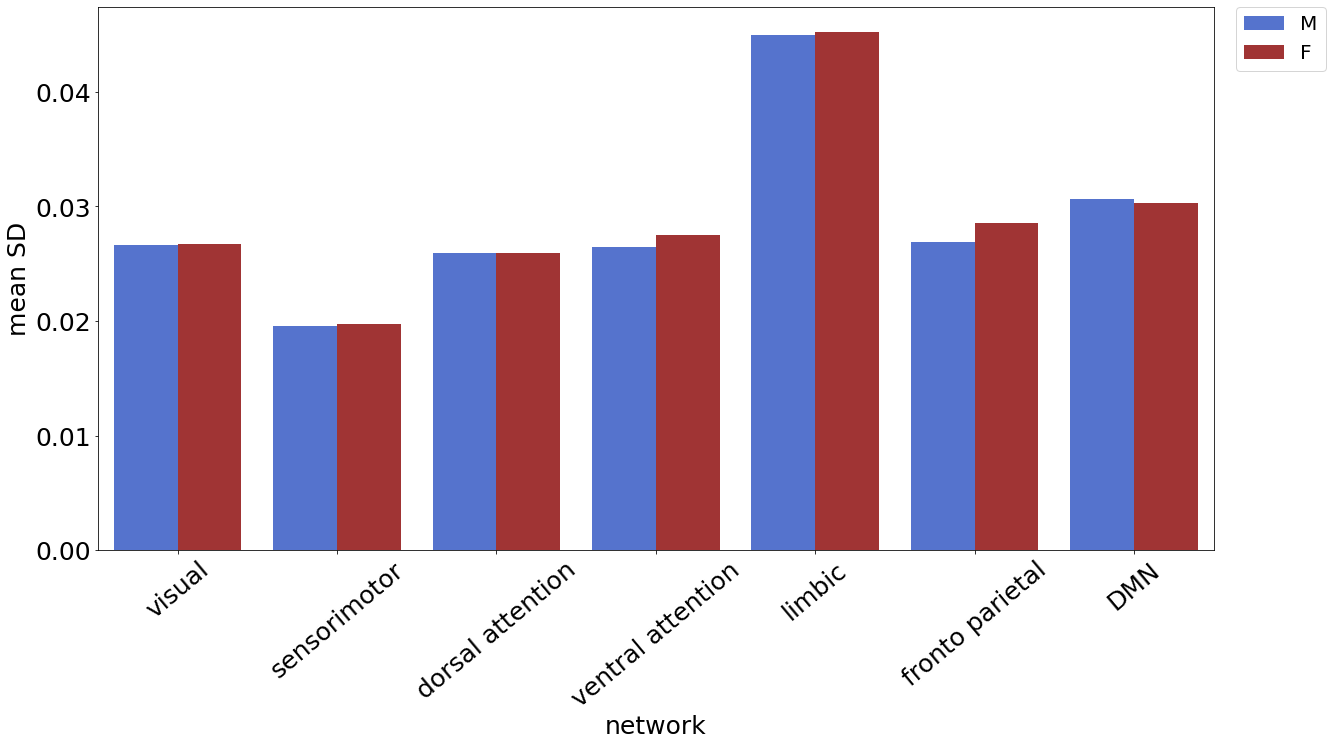

In [39]:
variability_network_std(subject_grad_M = array_aligned_fc_G1_M, subject_grad_F = array_aligned_fc_G1_F)

### c) Parcel level: Visualizing standard deviation by parcels in both sexes separately 
- these are the same values plotted in 2. (by function variability_parcel_std), only masking all but network of interest (spotlight approach)
- color bar standardized across all by taking min and max SD values


Minimum SD: Males = 0.013; Females = 0.014
Maximum SD: Males = 0.065; Females = 0.068


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


Males


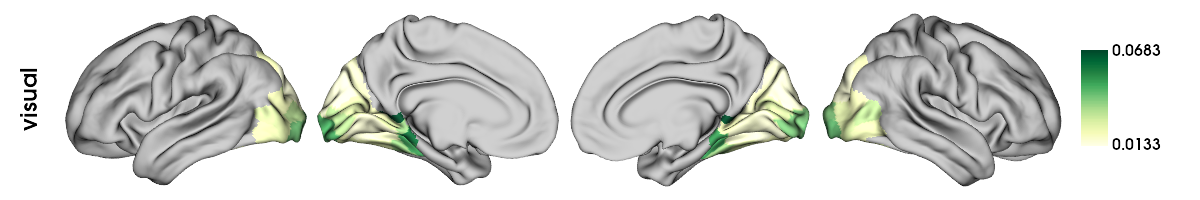

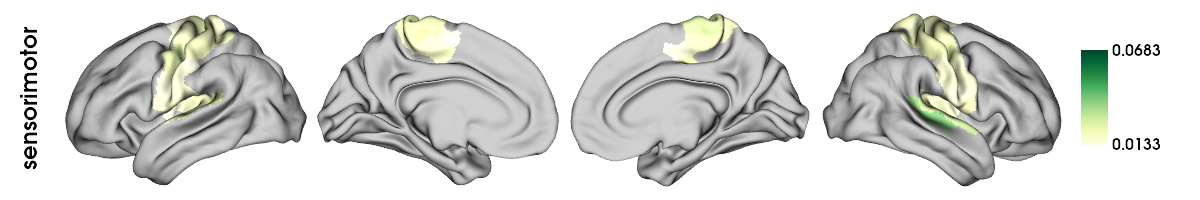

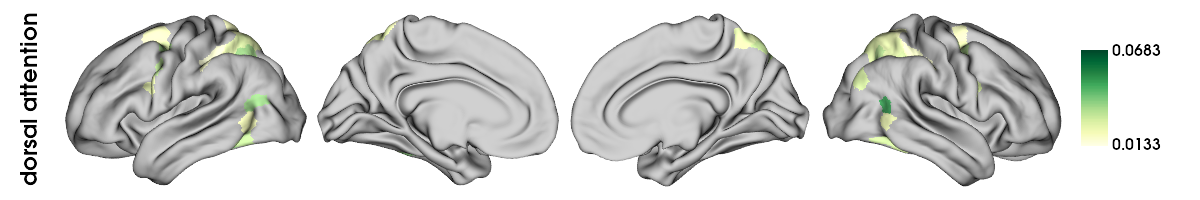

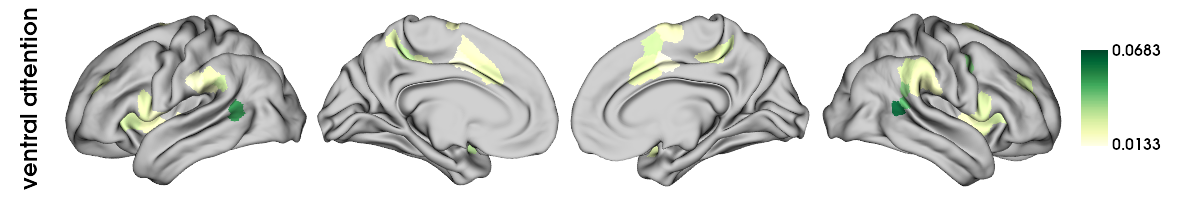

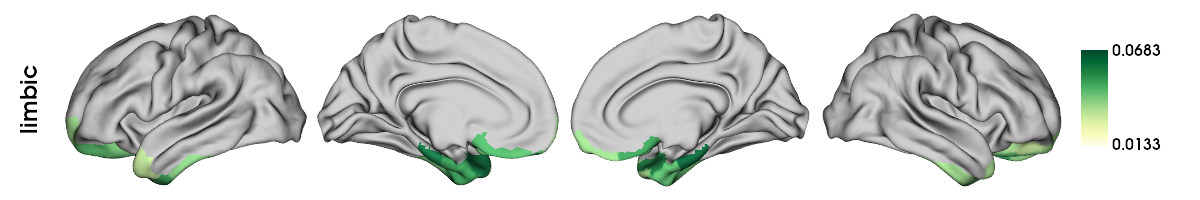

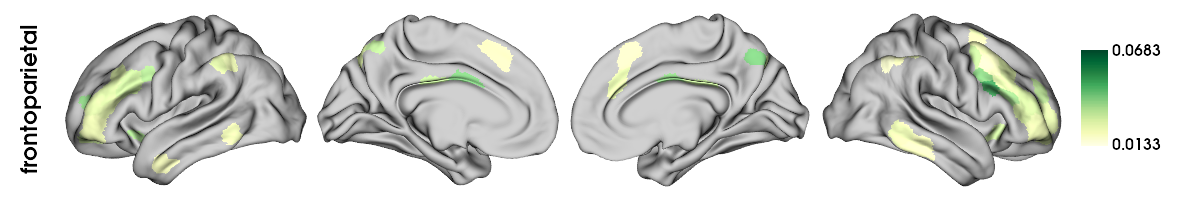

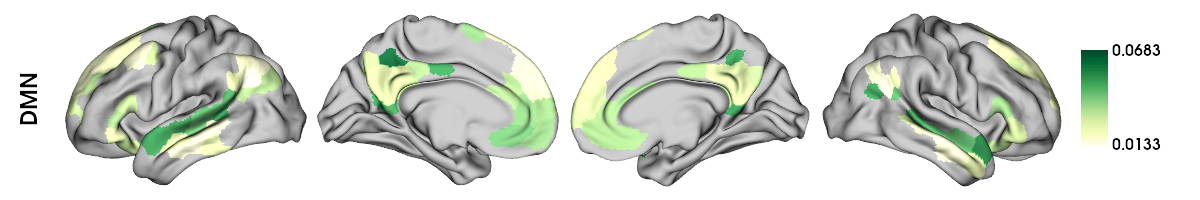

Females


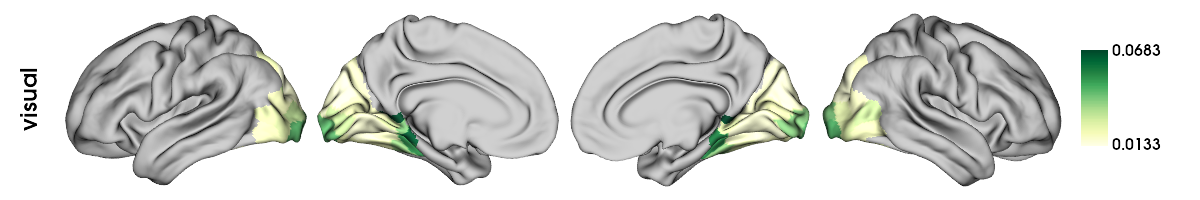

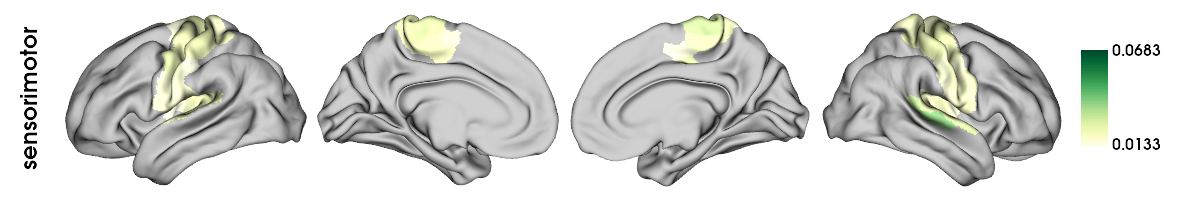

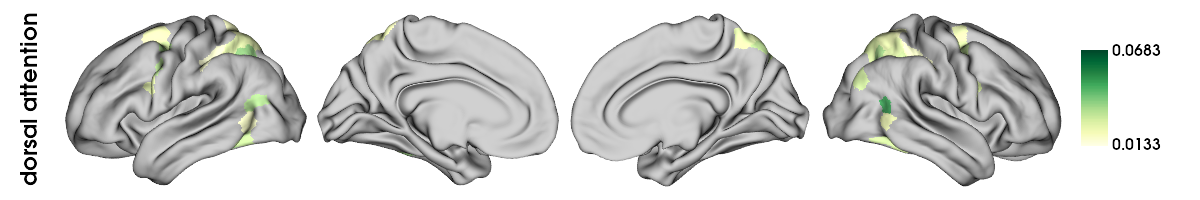

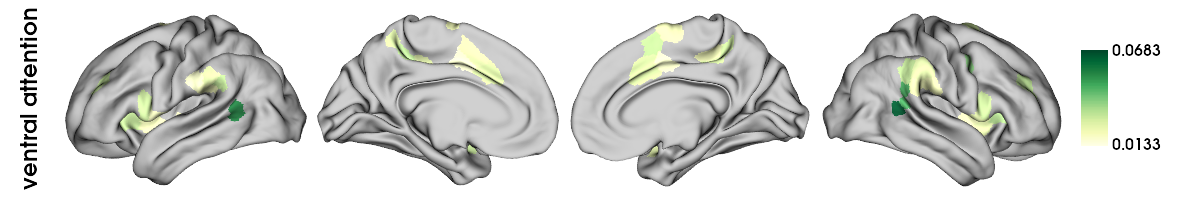

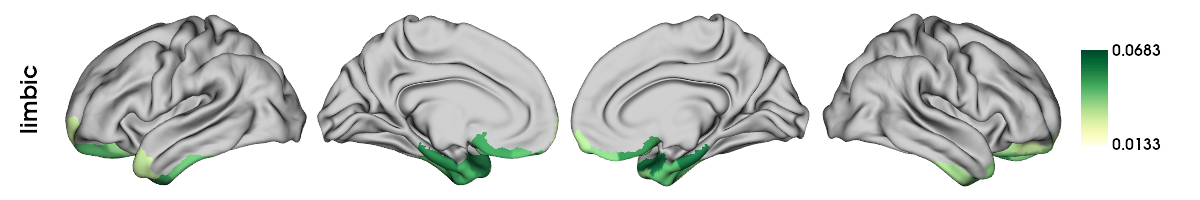

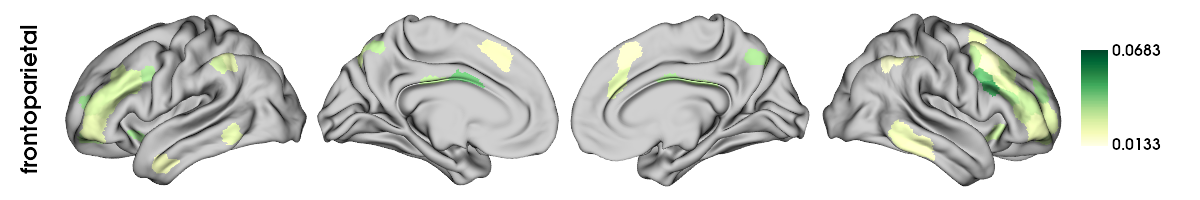

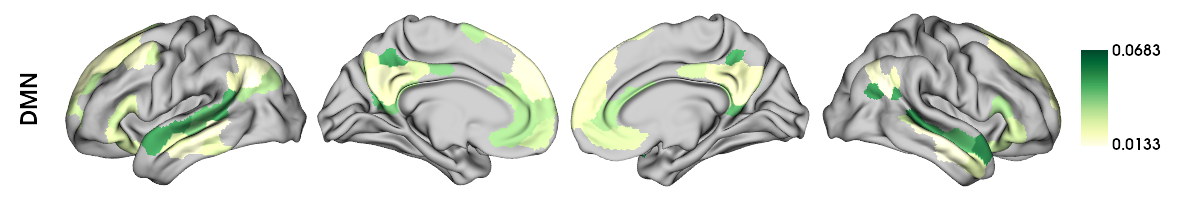

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)
/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/utils.py:367: RuntimeWarning: All-NaN slice encountered
  specs['min'][:] = np.nanmin(specs['min'], axis=ax, keepdims=True)
/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/utils.py:368: RuntimeWarning: All-NaN slice encountered
  specs['max'][:] = np.nanmax(specs['max'], axis=ax, keepdims=True)


difference score (M - F) of STD only for parcels who show statistical inhomogeneity of variance (i.e., Levene's test: p < 0.05)


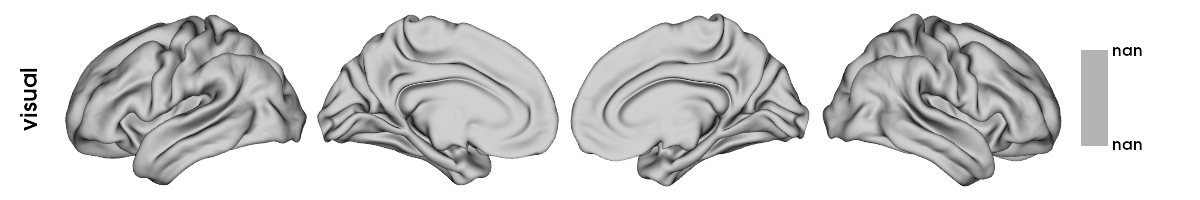

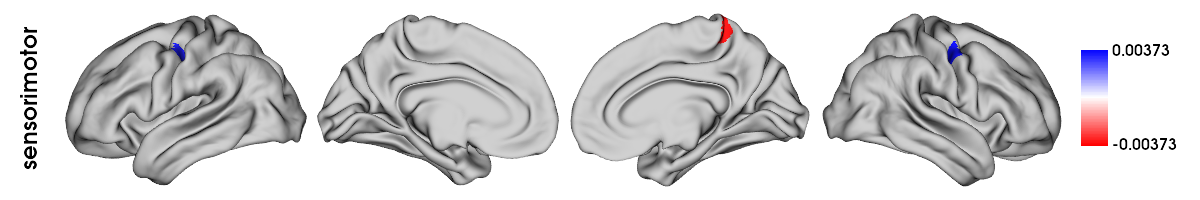

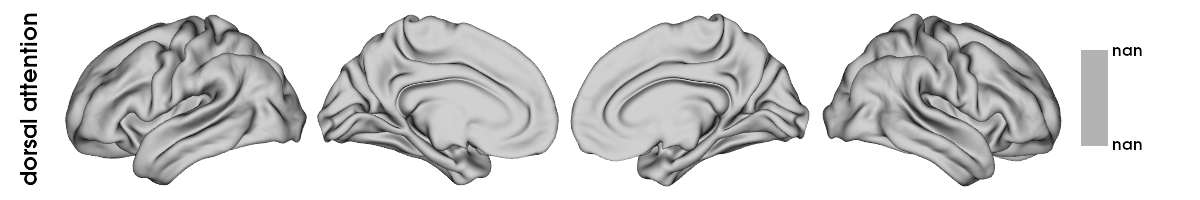

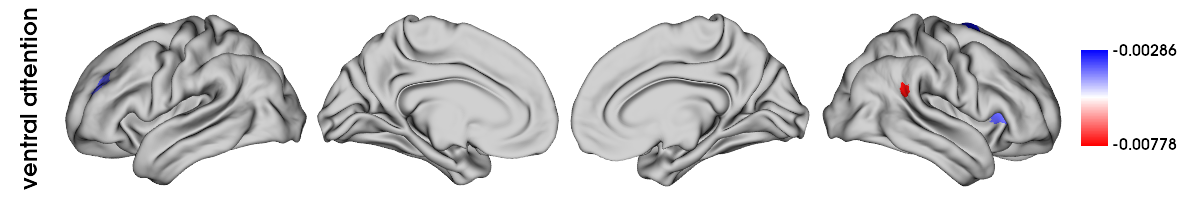

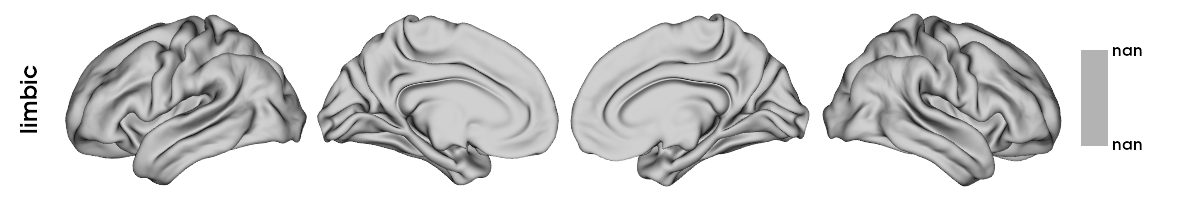

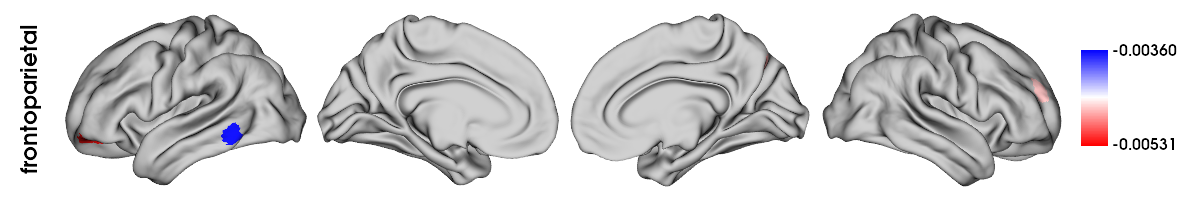

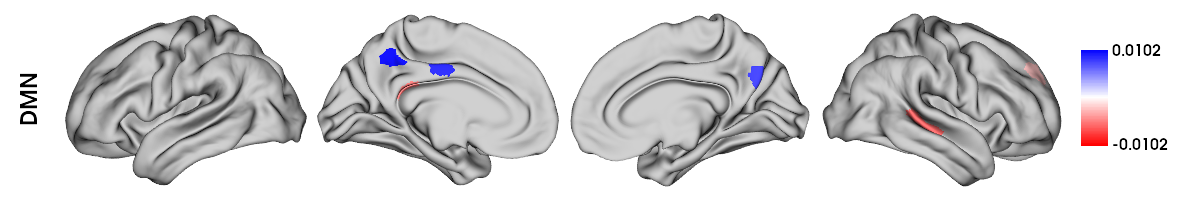

In [40]:
variability_parcel_std_spotlight_network(subject_grad_M = array_aligned_fc_G1_M, subject_grad_F = array_aligned_fc_G1_F)

# Visualizing functional gradients by network (and sex)

Using RainCloud plots https://github.com/RainCloudPlots/RainCloudPlots#python-environment

## Unimodal - Heteromodal gradient (G1 HCP)

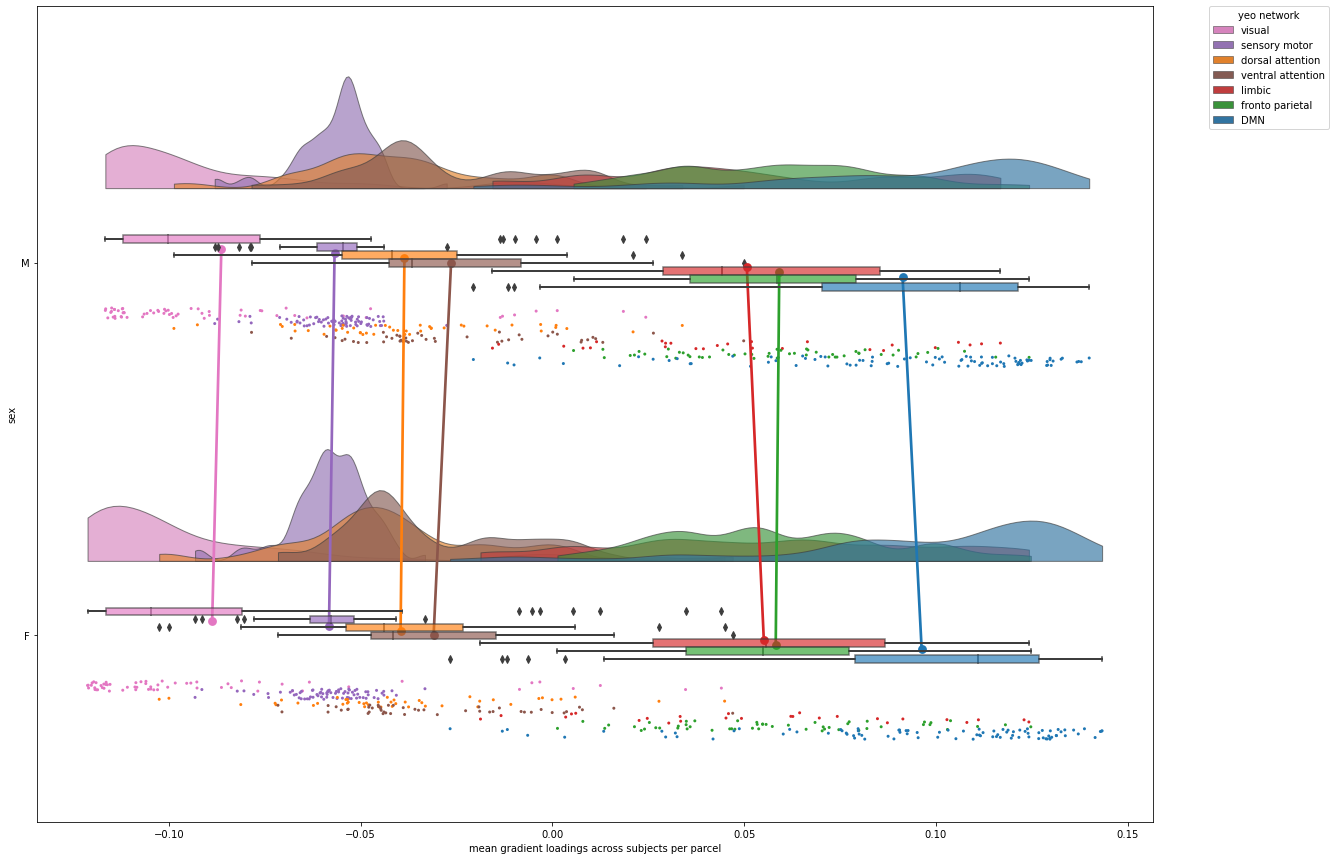

In [69]:
RainCloudPlot_YeoNetworks_SexComparison(array_grad = array_aligned_fc_G1, sex_comp = HCP_demographics_cleaned_final["Gender"])

# Sex effects functional gradients (standard linear regression - FDR-corrected 

In [42]:
# loading R results

# HCP model: linear mixed effects model = Gradient_loadings ~ Sex + Age + ICV + random effect family relatedness + random effect twin status + random effect (family relatedness * twin status) 
R_lmer_fc_G1_sex_contrast_res = pd.read_csv(resdir_hcp+'R_lmer_fc_G1_sex_contrast_res.csv')  
R_lmer_fc_G2_sex_contrast_res = pd.read_csv(resdir_hcp+'R_lmer_fc_G2_sex_contrast_res.csv')  
R_lmer_fc_G3_sex_contrast_res = pd.read_csv(resdir_hcp+'R_lmer_fc_G3_sex_contrast_res.csv')  

## Unimodal - Heteromodal gradient (G1 HCP)

Number of significant parcels: 134

Number of significant parcels for males: 82
Number of significant parcels for females: 52

Number of significant parcels in each Yeo network (across sexes):
- visual: 29 out of 61 (47.54%) -> 21.64% of overall significance
- sensory motor: 13 out of 77 (16.88%) -> 9.7% of overall significance
- DMN: 33 out of 90 (36.67%) -> 24.63% of overall significance
- dorsal attention: 6 out of 46 (13.04%) -> 4.48% of overall significance
- ventral attention: 30 out of 47 (63.83%) -> 22.39% of overall significance
- limbic: 5 out of 26 (19.23%) -> 3.73% of overall significance
- fronto parietal: 18 out of 53 (33.96%) -> 13.43% of overall significance





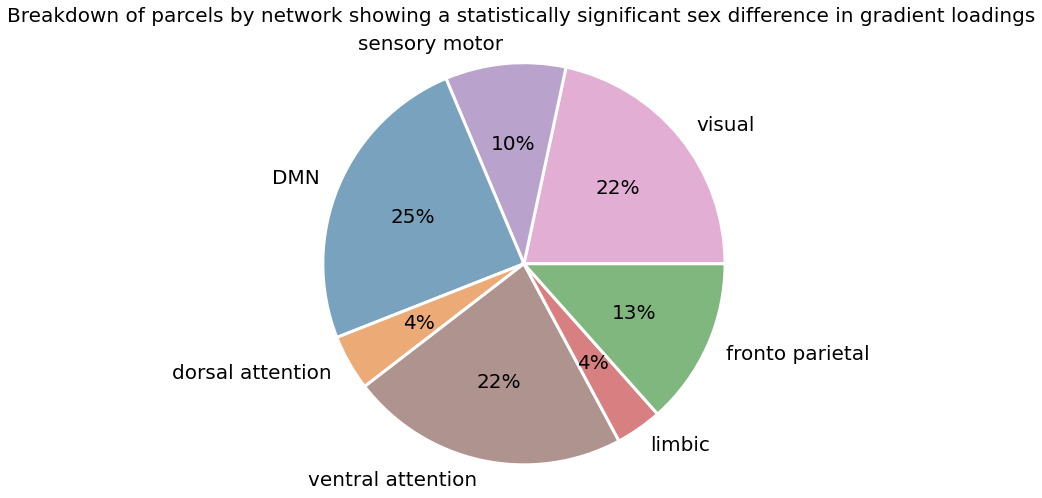

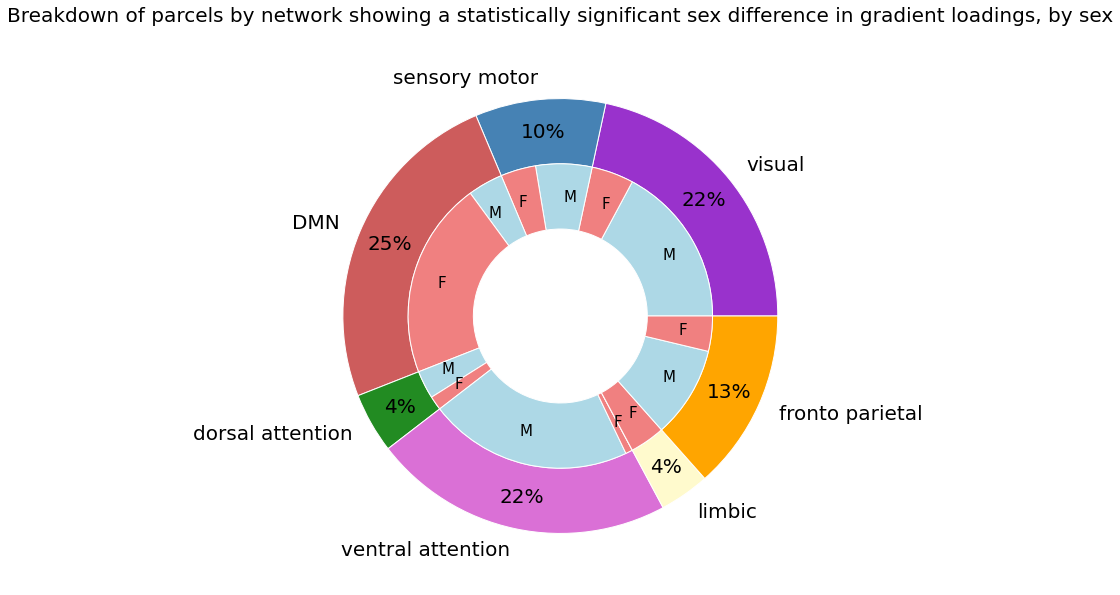

Number of significant parcels by sex:
visual - Male: 23, Female: 6
sensory motor - Male: 8, Female: 5
DMN - Male: 5, Female: 28
dorsal attention - Male: 4, Female: 2
ventral attention - Male: 29, Female: 1
limbic - Male: 0, Female: 5
fronto parietal - Male: 13, Female: 5





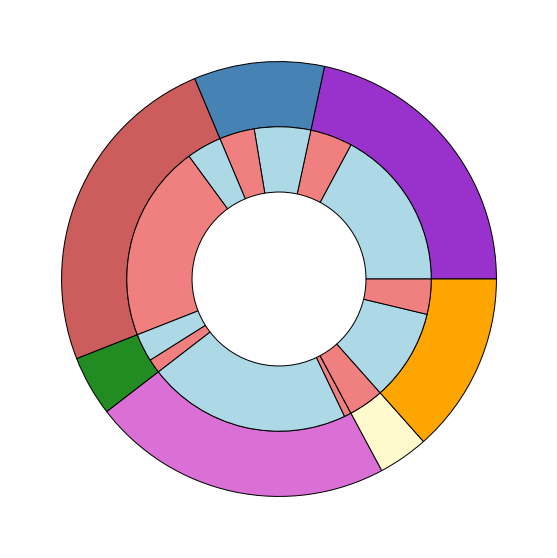




Violin plot of t-values (regression results) by Yeo network


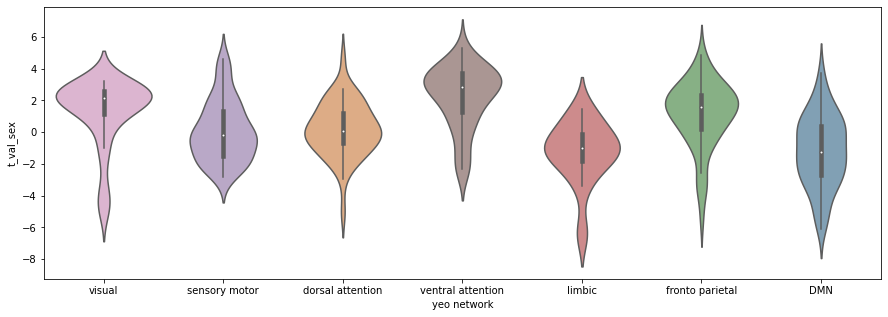

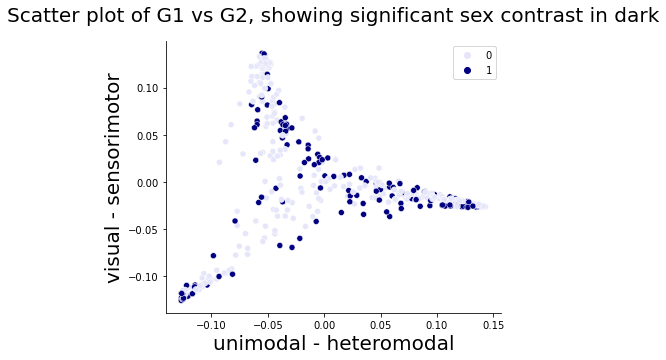

In [57]:
regression_contrast_results_breakdown_by_network(R_lmer_fc_G1_sex_contrast_res, contrast_type = 'sex', 
                                                 scatter_x = mean_fc_grad.gradients_[:,0], scatter_y = mean_fc_grad.gradients_[:,1], 
                                                 scatter_x_label = 'unimodal - heteromodal',  scatter_y_label = 'visual - sensorimotor',
                                                 sample_modality = 'HCP_fc_G1')

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


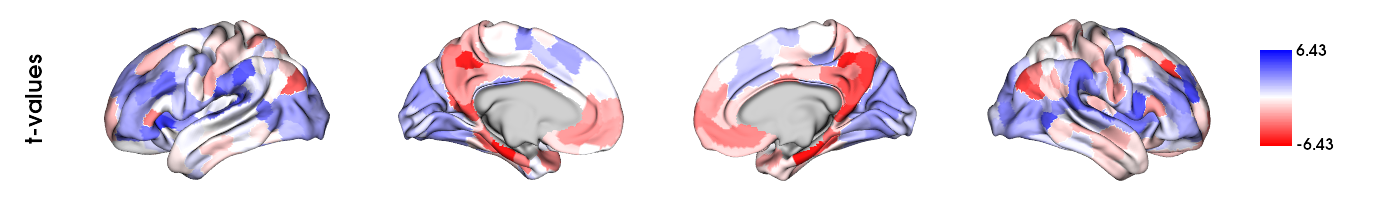

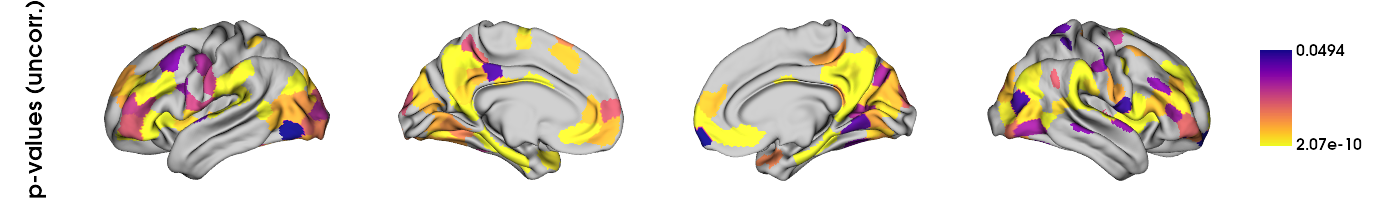

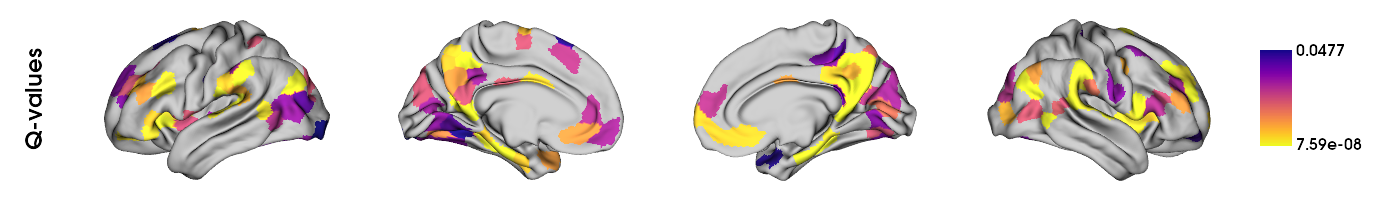

't-values for FDR-corrected q < 0.05: (male: blue, female: red)'

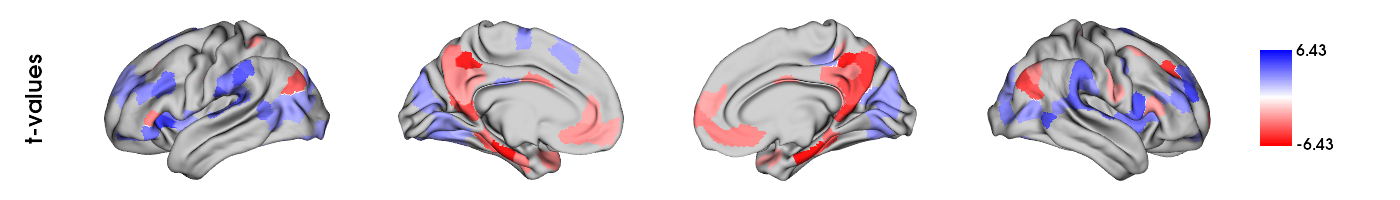

In [59]:
plots_to_display = plot_reg_results_R(R_lmer_fc_G1_sex_contrast_res, save_screenshot = False, sample_modality = 'HCP_fc_G1')
display(*plots_to_display)